In [21]:
import numpy as np
import pandas as pd
from pathlib import PurePath
from malt_temp.model import PINN_Model
from matplotlib import pyplot as plt
from malt_temp import initial_condition
from dataset.malt_dataset import MaltDataset
from torch.utils.data import DataLoader

import lightning.pytorch as pl

mash_data = pd.read_csv(PurePath("dataset", "Mash_Data.csv"))

In [2]:
mash_data.columns

Index(['Time', 'Temperature', 'AlfaAmilase', 'AlfaAmilase_Grain',
       'BetaAmilase', 'BetaAmilase_grain', 'Starch', 'Dextrins', 'Glucose',
       'Maltose', 'Maltotriose', 'Limit_Dextrins', 'SolidosFermentaveis',
       'SolidosNaoFermentaveis', 'SolidosTotais', 'PercFermentaveis',
       'Extrato', 'MashingEfficiency', 'Dp1', 'Dp2', 'Dp3', 'Dp4Plus'],
      dtype='object')

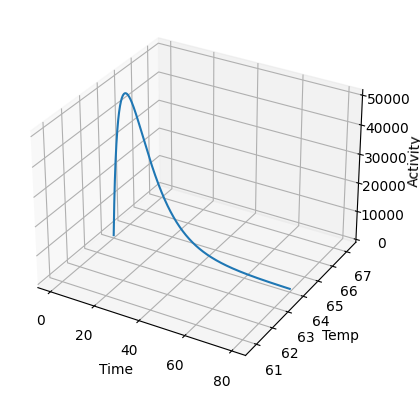

<Figure size 640x480 with 0 Axes>

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig = plt.figure()
ax.set(
    xlabel='Time',
    ylabel='Temp',
    zlabel='Activity',
)
ax = ax.plot(mash_data['Time'], mash_data['Temperature'], mash_data['BetaAmilase'])

### Dataset

In [4]:
dataset = MaltDataset(PurePath("dataset", "Mash_Data.csv"))

In [5]:
ic = initial_condition.InitialCondition(
    time = mash_data.iloc[0]['Time'],
    temperature = mash_data.iloc[0]['Temperature'],
    alpha_adjust = initial_condition.InitialAlfa_Adjust,
    grain_alpha_adjust = initial_condition.InitialGrainAlpha_Adjust,
    beta_adjust = initial_condition.InitialBeta_Adjust,
    grain_beta_adjust = initial_condition.InitialGrainBeta_Adjust
)

In [12]:
pinn_model = PINN_Model(nodes=3, layers=2, y0=ic)

In [24]:
class PLPinnModule(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model       

    def training_step(self, batch, batch_idx):        
        # train loop
        x, y = batch
        prediction = self.model(x)
        loss = F.mse_loss(prediction, x)
        self.log("train_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        x = x.view(x.size(0), -1)        
        test_loss = F.mse_loss(x_hat, x)
        self.log("test_loss", test_loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [18]:
pl.seed_everything(1234, workers=True)

Global seed set to 1234


1234

In [25]:
pl_model = PLPinnModule(pinn_model)
trainer = pl.Trainer()

# test the model
trainer.test(pl_model, dataloaders=DataLoader(dataset))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\ext.minh.triet.chau\code\malt_temp\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

ValueError: too many values to unpack (expected 2)